In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(72)
tf.random.set_seed(72)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



In [2]:
def evaluate_(model, generator_test):
    model.evaluate(generator_test)
    
    y_pred = model.predict(generator_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.show()

In [3]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import time

def evaluate_(model, generator_test):
    start_time = time.time()

    model.evaluate(generator_test)
    
    inference_time = time.time() - start_time
    print(f"Inference Time: {inference_time:.2f} seconds")

    start_time = time.time()
    y_pred = model.predict(generator_test)
    inference_time = time.time() - start_time
    print(f"Inference Time (prediction): {inference_time:.2f} seconds")

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator_test.classes
    class_labels = list(generator_test.class_indices.keys())

    print(classification_report(y_true, y_pred_classes))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    
    # ROC curve
    plt.subplot(1, 2, 2)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Call the function with your model and test generator
# evaluate_(your_model, your_generator_test)


In [4]:
train_dir = r"/kaggle/input/leaf-dataset/augmented/train"
test_dir = r"/kaggle/input/leaf-dataset/augmented/test"
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=(112, 112),
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=(112, 112),
                                                  batch_size=batch_size,
                                                  shuffle=False)
# Calculate class weights
labels = generator_train.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(zip(np.unique(labels), class_weights))
print(class_weights)

Found 5000 images belonging to 30 classes.
Found 2500 images belonging to 30 classes.
{0: 1.2820512820512822, 1: 0.4975124378109453, 2: 1.0101010101010102, 3: 1.016260162601626, 4: 0.5827505827505828, 5: 1.8726591760299625, 6: 0.778816199376947, 7: 1.2345679012345678, 8: 1.1111111111111112, 9: 0.9057971014492754, 10: 1.3440860215053763, 11: 0.8680555555555556, 12: 0.9009009009009009, 13: 0.6587615283267457, 14: 0.778816199376947, 15: 1.3123359580052494, 16: 0.9416195856873822, 17: 1.02880658436214, 18: 1.4880952380952381, 19: 1.1037527593818985, 20: 1.4492753623188406, 21: 1.3888888888888888, 22: 1.0040160642570282, 23: 1.0964912280701755, 24: 0.8169934640522876, 25: 0.8960573476702509, 26: 1.529051987767584, 27: 1.0964912280701755, 28: 1.1574074074074074, 29: 1.6181229773462784}


In [5]:
!pip install keras_cv_attention_models 

  Obtaining dependency information for keras_cv_attention_models from https://files.pythonhosted.org/packages/67/b4/a581ae34f6a37b021e32d1d874b8b7df4664cbb8a71659886193caf341e0/keras_cv_attention_models-1.3.22-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.8/183.8 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.2/773.2 kB 9.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstallin

In [23]:
from keras_cv_attention_models import res_mlp
# mm = res_mlp.ResMLP12()

In [8]:
from keras_cv_attention_models import swin_transformer_v2

In [10]:
mm = swin_transformer_v2.SwinTransformerV2Tiny_window8(input_shape=(112, 112, 3))

>>>> Load pretrained from: /root/.keras/models/swin_transformer_v2_tiny_window8_256_imagenet.h5


In [24]:
mm = res_mlp.ResMLP12(input_shape=(112, 112, 3), pretrained="imagenet")

>>>> Load pretrained from: /root/.keras/models/resmlp12_imagenet.h5


In [11]:
mm_last_layer = mm.get_layer('avg_pool').output
#out = Dense(256, activation='relu', name='dense_1')(mm_last_layer)
#out = Dense(11, activation='softmax', name='prediction1')(out)
mm_custom = Model(mm.input, mm_last_layer)

In [12]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model (Functional)          (None, 768)               27578154  
                                                                 
 average (Average)           (None, 768)               0         
                                                                 
Total params: 27578154 (105.20 MB)
Trainable params: 27578154 (105.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
from tensorflow.keras import layers
inputs = keras.Input(shape=(112,112,3))
outputs = layers.average([mm_custom(inputs)])

avg_ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
avg_ensemble_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model_4 (Functional)        (None, 384)               14531928  
                                                                 
 average_3 (Average)         (None, 384)               0         
                                                                 
Total params: 14531928 (55.43 MB)
Trainable params: 14531928 (55.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
num_classes = 30
avg_ensemble_model_last_layer = avg_ensemble_model.get_layer('average').output
output_layer = Dense(num_classes, activation='softmax', name='output_1')(avg_ensemble_model_last_layer)
final_model = Model(avg_ensemble_model.input, output_layer)

final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 model (Functional)          (None, 768)               27578154  
                                                                 
 average (Average)           (None, 768)               0         
                                                                 
 output_1 (Dense)            (None, 30)                23070     
                                                                 
Total params: 27601224 (105.29 MB)
Trainable params: 27601224 (105.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
# metrics = ['categorical_accuracy']
metrics = ['accuracy', 'categorical_accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 
           tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), 
           tf.keras.metrics.FalseNegatives(), tfa.metrics.CohenKappa(num_classes = num_classes), 
           tfa.metrics.F1Score(num_classes = num_classes)]

final_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,
    patience=9, mode="max", min_delta=0.0001, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(filepath='Best_DenseNet201_v23.h5', save_best_only=True, monitor = 'val_accuracy', verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

callbacks = [lr, checkpoint, early_stopping]

In [18]:
epochs = 30

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

history = final_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                   callbacks=callbacks, class_weight =class_weights)

/tmp/ipykernel_42/2027776823.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = final_model.fit_generator(generator=generator_train,


Epoch 1/30
313/312 [==============================] - ETA: 0s - loss: 3.1394 - accuracy: 0.0852 - categorical_accuracy: 0.0852 - auc: 0.6863 - precision: 0.2737 - recall: 0.0052 - true_positives: 26.0000 - true_negatives: 144931.0000 - false_positives: 69.0000 - false_negatives: 4974.0000 - cohen_kappa: 0.0558 - f1_score: 0.0882
Epoch 1: val_accuracy improved from -inf to 0.18200, saving model to Best_DenseNet201_v23.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


312/312 [==============================] - 220s 504ms/step - loss: 3.1394 - accuracy: 0.0852 - categorical_accuracy: 0.0852 - auc: 0.6863 - precision: 0.2737 - recall: 0.0052 - true_positives: 26.0000 - true_negatives: 144931.0000 - false_positives: 69.0000 - false_negatives: 4974.0000 - cohen_kappa: 0.0558 - f1_score: 0.0882 - val_loss: 2.6985 - val_accuracy: 0.1820 - val_categorical_accuracy: 0.1820 - val_auc: 0.8228 - val_precision: 0.4318 - val_recall: 0.0608 - val_true_positives: 152.0000 - val_true_negatives: 72300.0000 - val_false_positives: 200.0000 - val_false_negatives: 2348.0000 - val_cohen_kappa: 0.1550 - val_f1_score: 0.1002 - lr: 0.0010
Epoch 2/30
313/312 [==============================] - ETA: 0s - loss: 2.2679 - accuracy: 0.2546 - categorical_accuracy: 0.2546 - auc: 0.8879 - precision: 0.5316 - recall: 0.0538 - true_positives: 269.0000 - true_negatives: 144763.0000 - false_positives: 237.0000 - false_negatives: 4731.0000 - cohen_kappa: 0.2291 - f1_score: 0.2459
Epoch 2:

157/157 [==============================] - 22s 136ms/step - loss: 0.1231 - accuracy: 0.9668 - categorical_accuracy: 0.9668 - auc: 0.9960 - precision: 0.9683 - recall: 0.9656 - true_positives: 2414.0000 - true_negatives: 72421.0000 - false_positives: 79.0000 - false_negatives: 86.0000 - cohen_kappa: 0.9656 - f1_score: 0.9660
Inference Time: 21.71 seconds
157/157 [==============================] - 25s 140ms/step
Inference Time (prediction): 25.49 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       0.97      0.97      0.97       153
           2       1.00      1.00      1.00        84
           3       1.00      1.00      1.00        72
           4       0.89      1.00      0.94       124
           5       0.82      1.00      0.90        47
           6       0.96      1.00      0.98        99
           7       0.96      0.95      0.96        84
           8       1.00      0.82      0.90        66
  

/tmp/ipykernel_42/23535308.py:55: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


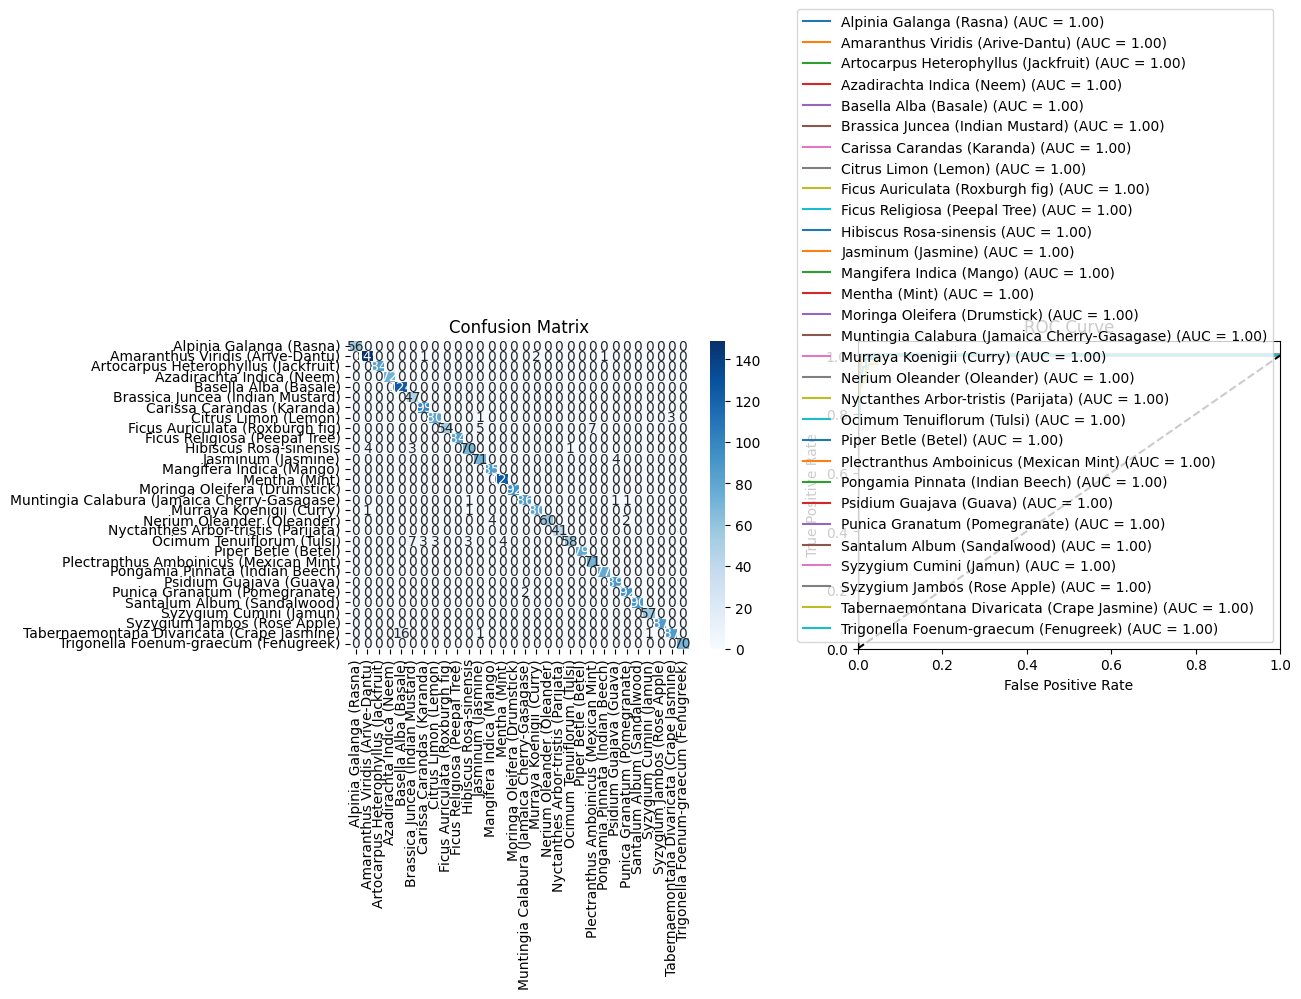

In [19]:
evaluate_(final_model, generator_test)

In [7]:
from keras_cv_attention_models import wave_mlp

In [8]:
pip install keras-self-attention


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=fe1c42f6d748e5fe7f57acfa384eef08bb3bdd5d3aae089b20849df5d2c2916f
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention
Note: you may need to restart the kernel to use updated packages.


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Layer, Add, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras import Input, Model
# Import your wave_mlp module

class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_q = self.add_weight(name='W_q', shape=(input_shape[-1], input_shape[-1]),
                                   initializer='uniform', trainable=True)
        self.W_k = self.add_weight(name='W_k', shape=(input_shape[-1], input_shape[-1]),
                                   initializer='uniform', trainable=True)
        self.W_v = self.add_weight(name='W_v', shape=(input_shape[-1], input_shape[-1]),
                                   initializer='uniform', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        q = x @ self.W_q
        k = x @ self.W_k
        v = x @ self.W_v

        attn_score = tf.matmul(q, k, transpose_b=True)
        attn_score = tf.nn.softmax(attn_score, axis=-1)

        output = attn_score @ v
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

class PositionalEncoding(Layer):
    def __init__(self, input_shape, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.input_shape_ = input_shape

    def build(self, input_shape):
        self.positional_encoding = self.add_weight(name='positional_encoding',
                                                   shape=(1, *self.input_shape_[1:], 1),
                                                   initializer='uniform',
                                                   trainable=True)
        super(PositionalEncoding, self).build(input_shape)

    def call(self, x):
        return x + self.positional_encoding

    def compute_output_shape(self, input_shape):
        return input_shape

def custom_head(input_tensor, num_classes):
    x = Flatten()(input_tensor)
    x = Dense(256, activation='relu')(x)  # Add your own dense layers
    x = Dropout(0.5)(x)  # Add dropout for regularization

    # Add self-attention mechanism
    self_attention = SelfAttention()(x)
    x = Add()([x, self_attention])

    # Add 2D positional encoding
    position_encoding = PositionalEncoding(input_shape=(1, 1, 256))(x)  # Adjust the input_shape
    x = Add()([x, position_encoding])

    x = Dense(num_classes, activation='softmax')(x)
    return x

def stage_block(x, filters, num_blocks, attention=True, hdc=False):
    # Check if the input is flattened
    if len(x.shape) == 2:
        # Reshape to 4D tensor
        x = tf.reshape(x, [-1, int(x.shape[1] ** 0.5), int(x.shape[1] ** 0.5), 1])

    for _ in range(num_blocks):
        # Residual block
        residual = x

        # Global self-attention
        if attention:
            x = SelfAttention()(x)

        # Convolutional layer with Hybrid Dilated Convolution (HDC)
        if hdc:
            x = Conv2D(filters, kernel_size=(3, 3), dilation_rate=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Conv2D(filters, kernel_size=(3, 3), dilation_rate=(3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        # Residual connection (adjusting the residual size)
        residual = Conv2D(filters, kernel_size=(1, 1), padding='same')(residual)
        x = Add()([x, residual])

    # MaxPooling for downsampling
    x = MaxPooling2D(pool_size=(2, 2))(x)

    return x

def modify_wave_mlp(input_shape, num_classes):
    # Load the WaveMLP model without the top layers (head)
    mm_headless = wave_mlp.WaveMLP_T(input_shape=input_shape, pretrained="imagenet")
    x = mm_headless.output

#     # Stage 1 with HDC
#     x = stage_block(mm_headless.output, filters=64, num_blocks=3, hdc=True)

#     # Stage 2 with HDC
#     x = stage_block(x, filters=128, num_blocks=3, hdc=True)

    # Stage 3 with HDC
    x = stage_block(x, filters=256, num_blocks=3, hdc=True)

#     # Stage 4 (Residual blocks)
#     x = stage_block(x, filters=512, num_blocks=3, attention=False, hdc=False)

    # Custom head
    head_output = custom_head(x, num_classes)

    # Create the custom model by combining the base model and the custom head
    custom_model = Model(inputs=mm_headless.input, outputs=head_output)

    return custom_model

# Example usage:
input_shape = (112, 112, 3)
num_classes = 26  # Adjust based on your task

custom_model = modify_wave_mlp(input_shape, num_classes)
custom_model.summary()


>>>> Load pretrained from: /root/.keras/models/wavemlp_t_imagenet.h5
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 stem_pad (ZeroPadding2D)    (None, 116, 116, 3)          0         ['input_6[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 28, 28, 64)           9472      ['stem_pad[0][0]']            
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 28, 28, 64)           256       ['stem_conv[0][0]']           
 n)                    